#Acciones de Doge-USD
##Instalamos las librerias



In [4]:
# necesitamos la libreria WIKITABLES para descargar tablas de Wikipedia (y mantener actualizada la data)
# Necesitamos la libreria FSSPEC (Interfaces de sistema de archivos para Python)
# Necesitamos la libreria  beautifulsoup4 : para raspado web altamente evolucionadas
#!pip install wikitables
!pip install fsspec
!pip install beautifulsoup4 

##Importamos librerias

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D   #para graficas en 3D

import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

#from wikitables import import_tables    # para descargar tablas de Wikipedia
from sklearn.decomposition import PCA   # Análisis de componentes principales (PCA).

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##Importamos el dataset

In [6]:
df_acciones = pd.read_csv("https://raw.githubusercontent.com/iFePax/DeepLearning/main/Datasets/DIS.csv")
df_acciones.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.092908,0.096026,0.092908,0.092908,0.058398,841958
1,1962-01-03,0.092908,0.094467,0.092908,0.094155,0.059182,801865
2,1962-01-04,0.094155,0.094467,0.093532,0.094155,0.059182,962238
3,1962-01-05,0.094155,0.094779,0.093844,0.094467,0.059378,962238
4,1962-01-08,0.094467,0.095714,0.092285,0.094155,0.059182,1282984


##Conociendo y preprocesando los datos

In [7]:
#df.describe()
df_acciones.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

##Eliminamos las filas vacias
Se eliminan los datos vacios (NA) y se resetea el indice

In [8]:
df_acciones = df_acciones.dropna()   # Se eliminan filas que tengan valor NaN.
df_acciones = df_acciones.reset_index(drop=True)

##Cambiamos el tipo de dato en las columnas


In [9]:
df_acciones['Date']=pd.to_datetime(df_acciones['Date'])       # Convertimos el campo DATE en tipo fecha
##df_acciones = df_acciones.rename(columns={'Name':'symbol'})   #cambiamos el nombre la col de NAME a  SYMBOL
df_acciones.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.092908,0.096026,0.092908,0.092908,0.058398,841958
1,1962-01-03,0.092908,0.094467,0.092908,0.094155,0.059182,801865
2,1962-01-04,0.094155,0.094467,0.093532,0.094155,0.059182,962238
3,1962-01-05,0.094155,0.094779,0.093844,0.094467,0.059378,962238
4,1962-01-08,0.094467,0.095714,0.092285,0.094155,0.059182,1282984


##Definimos las columnas que se usaran

In [10]:
open_table = df_acciones[['Date', 'Open']]
open_table.head()

,Date,Open
0,1962-01-02,0.092908
1,1962-01-03,0.092908
2,1962-01-04,0.094155
3,1962-01-05,0.094155
4,1962-01-08,0.094467


In [11]:
close_table = df_acciones[['Date', 'Close']]
close_table.head()

,Date,Close
0,1962-01-02,0.092908
1,1962-01-03,0.094155
2,1962-01-04,0.094155
3,1962-01-05,0.094467
4,1962-01-08,0.094155


##Invertimos el dataframe para tener las acciones por fecha 

In [128]:
##NO CORRER
#colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda
open_table = open_table.pivot(index='Date', columns='Open', values='Open')
open_table = open_table.dropna(axis=1)    #borramos filas vacias
open_table.head(5)

Open
Date
1962-01-02
1962-01-03
1962-01-04
1962-01-05
1962-01-08


##Normalización de los datos usando como base la fecha

---
Puede decidir volver a muestrear los datos:

*  W - para datos semanales
*  M - para datos mensuales
*  Q - para el trimestre
*  A - por año

In [12]:
open_table['Date'] = pd.to_datetime(open_table['Date'])
close_table['Date'] = pd.to_datetime(close_table['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
open_table = open_table.resample('W', on='Date').sum()
close_table = close_table.resample('W', on='Date').sum()

##Graficamos los datos

In [16]:
#funcion para sacar el  nombre de las empresas segun  su sigla
def plot_stock(symbol, df_acciones=df_acciones):
    df_acciones[symbol].plot(alpha=2);

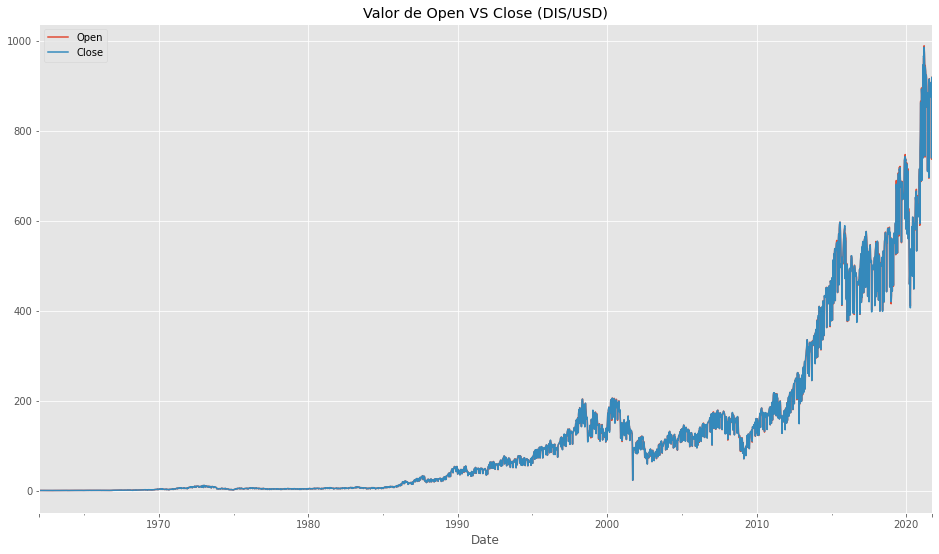

In [139]:
plot_stock('Open')
plot_stock('Close')
plt.title('Valor de Open VS Close (DIS/USD)')
plt.legend();

##Grafica elbow o de codo

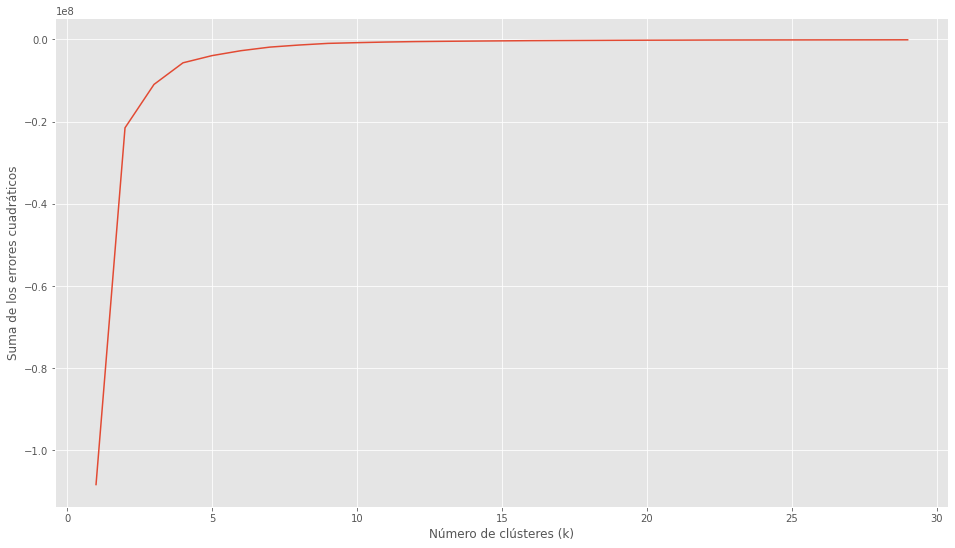

In [20]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(open_table).score(open_table) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

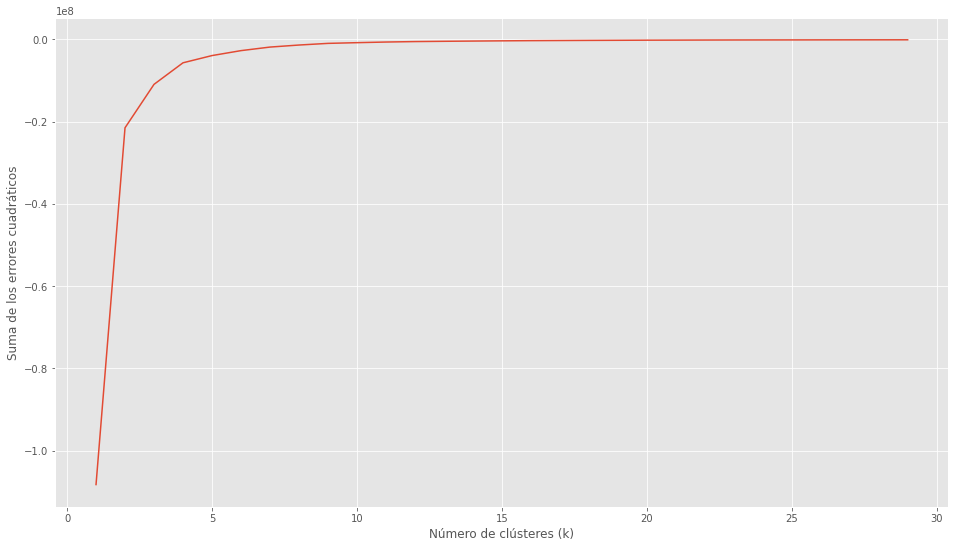

In [21]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(close_table).score(close_table) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

##Aplicar el algoritmo de K-mean

In [23]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(open_table)
centroids = kmeans.cluster_centers_
print(centroids)   #coordenadas de los centroides

[[ 15.62665134]
 [549.78457317]
 [141.42278282]
 [388.68182434]
 [812.37492171]]


In [24]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(close_table)
centroids = kmeans.cluster_centers_
print(centroids)   #coordenadas de los centroides

[[141.62168048]
 [550.29127597]
 [ 15.70770337]
 [813.62452958]
 [388.65216259]]
